##图像分类
本教程说明如何根据图像对猫或狗进行分类。它使用`tf.keras.Sequential`模型构建图像分类器，并使用加载数据`tf.keras.preprocessing.image.ImageDataGenerator`。您将获得一些实践经验，并对以下概念有了直觉：

* 使用该类构建数据输入管道，`tf.keras.preprocessing.image.ImageDataGenerator`以有效地处理磁盘上的数据以供模型使用。
* 过度拟合 -如何识别和预防。
* 数据增强和辍学 -Key技术打在计算机视觉任务的过度拟合并入数据管道和图像分类模型。

本教程遵循基本的机器学习工作流程：

1. 检查并了解数据
2. 建立输入管道
3. 建立模型
4. 训练模型
5. 测试模型
6. 改进模型并重复该过程
##导入包
让我们从导入所需的包开始。该os软件包用于读取文件和目录结构，NumPy用于将python列表转换为numpy数组，并执行所需的矩阵运算，matplotlib.pyplot并在训练和验证数据中绘制图形并显示图像。

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
from __future__ import absolute_import,division,print_function,unicode_literals
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,Dropout,MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt


###载入资料
首先下载数据集。本教程使用Kaggle 的Dogs vs Cats数据集的过滤版本。下载数据集的存档版本，并将其存储在“/tmp/”目录中

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip',origin=_URL,extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip),'cats_and_dogs_filtered')

68608000/68606236 [==============================] - 1s 0us/step


数据集具有以下目录结构：

In [5]:
%ls {path_to_zip}

/root/.keras/datasets/cats_and_dogs.zip


提取其内容后，为变量分配适当的文件路径以用于训练和验证集。

In [0]:
train_dir = os.path.join(PATH,'train')
validation_dir = os.path.join(PATH,'validation')

In [0]:
train_cats_dir = os.path.join(train_dir,'cats')
train_dogs_dir = os.path.join(train_dir,'dogs')
validation_cats_dir = os.path.join(validation_dir,'cats')
validation_dogs_dir = os.path.join(validation_dir,'dogs')

###了解数据
让我们看看训练和验证目录中有多少只猫和狗的图像：

In [0]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [10]:
print('训练猫：',num_cats_tr)
print('训练狗：',num_dogs_tr)

print('训练数据：',total_train)

print('-----------')

print('验证猫：',num_cats_val)
print('验证狗：',num_dogs_val)

print('验证数据：',total_val)

训练猫： 1000
训练狗： 1000
训练数据： 2000
-----------
验证猫： 500
验证狗： 500
验证数据： 1000


为了方便起见，设置变量以在预处理数据集和训练网络时使用。

In [0]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150


##资料准备
在将图像馈送到网络之前，将图像格式化为经过适当预处理的浮点张量：

1. 从磁盘读取图像。
2. 解码这些图像的内容，并根据其RGB内容将其转换为正确的网格格式。
3. 将它们转换为浮点张量。
4. 将张量从0到255之间的值重新缩放为0到1之间的值，因为神经网络更喜欢处理较小的输入值。

幸运的是，所有这些任务都可以通过提供的`tf.keras.ImageDataGenerator`类来完成。它可以从磁盘读取图像并将其预处理为适当的张量。它还将设置将这些图像转换成张量的生成器，这对于训练网络很有帮助。

In [0]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

在定义用于训练和验证图像的生成器之后，该flow_from_directory方法从磁盘加载图像，应用重新缩放，然后将图像调整为所需的尺寸。

In [17]:
train_data_gen = train_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_HEIGHT,IMG_WIDTH),
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.


In [18]:
val_data_gen = validation_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=validation_dir,
    target_size=(IMG_HEIGHT,IMG_WIDTH),
    class_mode='binary'
)

Found 1000 images belonging to 2 classes.


###可视化训练图像
通过从训练生成器中提取一批图像（在此示例中为32张图像）来可视化训练图像，然后使用绘制其中的五幅matplotlib。

In [0]:
sample_training_images,_ = next(train_data_gen)

该next函数从数据集中返回一批。next函数的返回值采用以下形式：(x_train, y_train)x_train是训练特征，y_train是其标签。丢弃标签以仅显示训练图像。

In [0]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

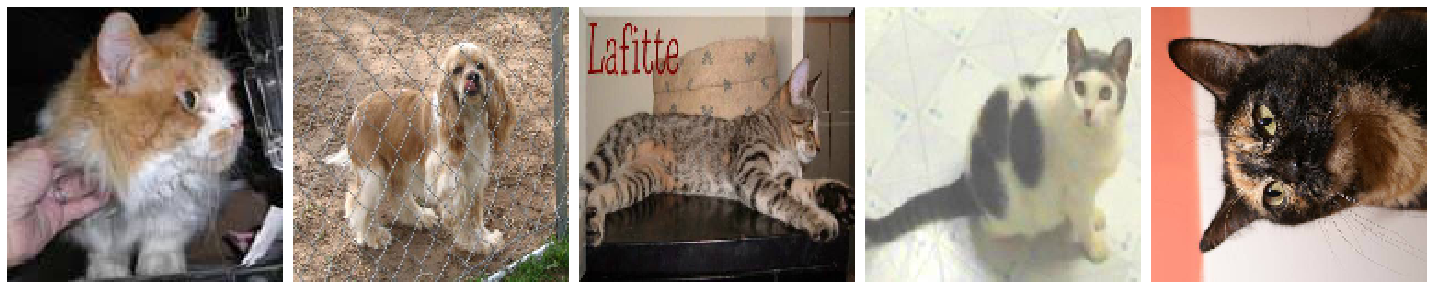

In [26]:
plotImages(sample_training_images[:5])

###创建模型
该模型由三个卷积块组成，每个卷积块中都有一个最大池层。有一个完全连接的层，上面有512个单元，可以通过relu激活功能激活。该模型根据sigmoid激活函数基于二进制分类输出类概率。

In [0]:
model = Sequential([
  Conv2D(16,3,padding='same',activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH,3)),
  MaxPool2D(),
  Conv2D(32,3,padding='same',activation='relu'),
  MaxPool2D(),
  Conv2D(64,3,padding='same',activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(512,activation='relu'),
  Dense(1,activation='sigmoid')
])

###编译模型
在本教程中，选择ADAM优化器和二进制交叉熵损失函数。要查看每个训练时期的训练和验证准确性，请传递metrics参数。

In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

###模型概览
使用模型的summary方法查看网络的所有层：


In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

###训练模型
使用该类的fit_generator方法ImageDataGenerator来训练网络。

In [33]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val//batch_size
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 15 steps, validate for 7 steps
Epoch 1/15
15/15 [==============================] - 56s 4s/step - loss: 0.9848 - accuracy: 0.5047 - val_loss: 0.6921 - val_accuracy: 0.4933
Epoch 2/15
15/15 [==============================] - 53s 4s/step - loss: 0.6910 - accuracy: 0.5214 - val_loss: 0.6839 - val_accuracy: 0.5179
Epoch 3/15
15/15 [==============================] - 53s 4s/step - loss: 0.6814 - accuracy: 0.5524 - val_loss: 0.6557 - val_accuracy: 0.6306
Epoch 4/15
15/15 [==============================] - 53s 4s/step - loss: 0.6532 - accuracy: 0.6362 - val_loss: 0.6258 - val_accuracy: 0.6797
Epoch 5/15
15/15 [==============================] - 53s 4s/step - loss: 0.6291 - accuracy: 0.6389 - val_loss: 0.6164 - val_accuracy: 0.6451
Epoch 6/15
15/15 [==============================] - 53s 4s/step - loss: 0.5818 - accuracy: 0.7105 - val_loss: 0.5845 - val_accuracy: 

###可视化培训结果
现在在训练网络后可视化结果。

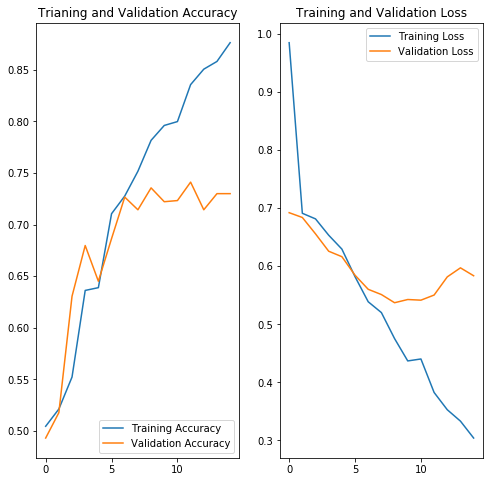

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Trianing and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

从图中可以看到，训练准确性和验证准确性相差很大，模型仅在验证集上获得了约70％的准确性。

让我们看一下出了什么问题，并尝试提高模型的整体性能。

###过度拟合
在上面的图中，训练精度随时间呈线性增长，而验证精度在训练过程中停滞在70％左右。同样，训练和验证准确性之间的准确性差异也很明显，这是过度拟合的标志。

当训练样本数量很少时，该模型有时会从训练样本中的噪音或不必要的细节中学习，以至于对新样本的模型性能产生负面影响。这种现象称为过拟合。这意味着该模型很难推广到新的数据集。

在训练过程中，有多种方法可以解决过拟合的问题。在本教程中，您将使用数据扩充并将遗漏添加到我们的模型中。

###数据增加
当培训实例数量很少时，过度拟合通常会发生。解决此问题的一种方法是扩充数据集，使其具有足够数量的训练示例。数据增强采用通过使用产生真实感图像的随机变换增强样本来从现有训练样本生成更多训练数据的方法。目标是模型在训练期间永远不会看到两次完全相同的图片。这有助于使模型暴露于数据的更多方面，并且可以更好地进行概括。

`tf.keras`使用`ImageDataGenerator`类来实现这一点。将不同的转换传递给数据集，它将在训练过程中加以应用。

###扩充和可视化数据
首先将随机水平翻转增强应用于数据集，然后查看变换后各个图像的外观。

###应用水平翻转
通过`horizontal_flip`作为参数传递给`ImageDataGenerator`类，并将其设置`True`到应用此增强。

In [0]:
image_gen = ImageDataGenerator(rescale=1./255,horizontal_flip=True)

In [37]:
train_data_gen = image_gen.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_HEIGHT,IMG_WIDTH)
)

Found 2000 images belonging to 2 classes.


从训练示例中获取一个样本图像，并将其重复五次，以便将增强应用于同一图像五次。

In [0]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

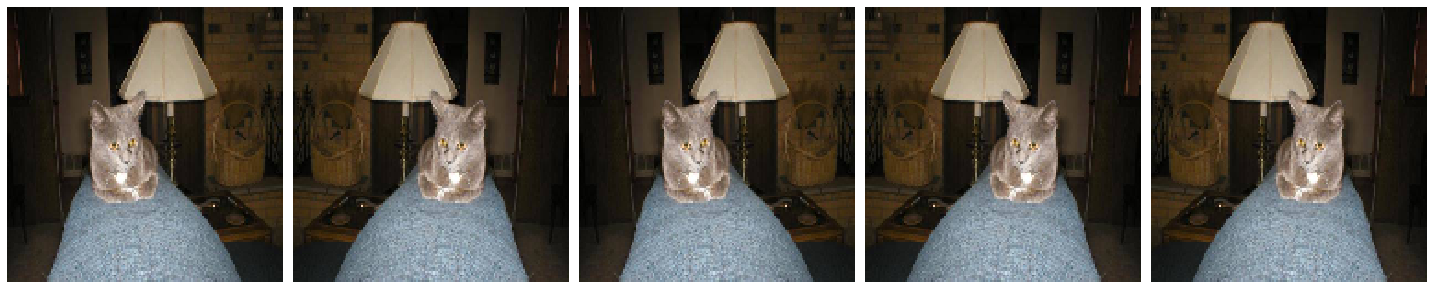

In [39]:
plotImages(augmented_images)

###随机旋转图像
让我们看一下另一种称为旋转的增强，并将随机45度旋转应用于训练示例。

In [0]:
image_gen = ImageDataGenerator(rescale=1./255,rotation_range=45)

In [41]:
train_data_gen = image_gen.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_HEIGHT,IMG_WIDTH)
)
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 2000 images belonging to 2 classes.


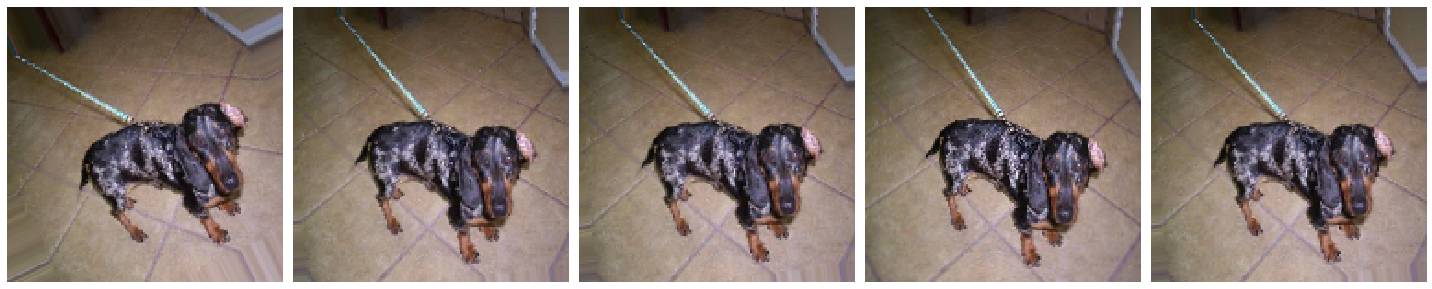

In [42]:
plotImages(augmented_images)

###应用放大增强
将缩放增强应用于数据集以将图像随机缩放到50％。

In [0]:
#zoom_range from 0-1 where 1=100%
image_gen = ImageDataGenerator(rescale=1./255,zoom_range=0.5)

In [44]:
train_data_gen = image_gen.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_HEIGHT,IMG_WIDTH)
)
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 2000 images belonging to 2 classes.


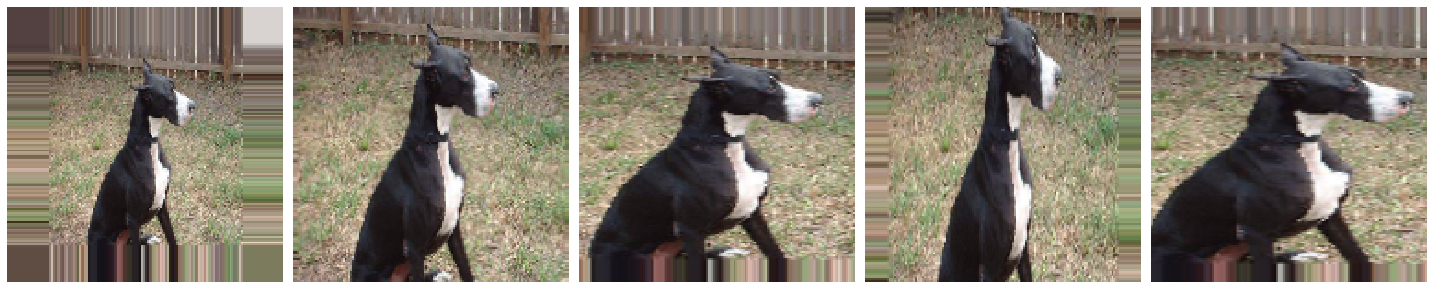

In [45]:
plotImages(augmented_images)

###放在一起
应用所有以前的扩充。在这里，您对训练图像应用了重新缩放，45度旋转，宽度偏移，高度偏移，水平翻转和缩放增强。

In [0]:
image_gen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=.15,
    height_shift_range=.15,
    horizontal_flip=True,
    zoom_range=0.5
)

In [47]:
train_data_gen = image_gen_train.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_HEIGHT,IMG_WIDTH),
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.


可视化将这些扩充随机传递到数据集时，单个图像在五个不同时间的外观。

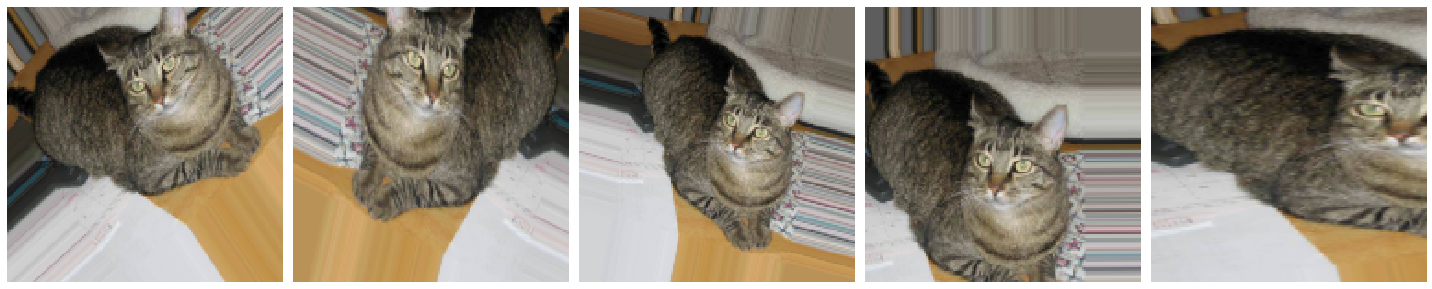

In [48]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

###创建验证数据生成器
通常，仅将数据扩充应用于训练示例。在这种情况下，仅重新缩放验证图像，然后使用将它们转换为批次ImageDataGenerator。

In [0]:
image_gen_val = ImageDataGenerator(rescale=1./255)

In [50]:
val_data_gen = image_gen_val.flow_from_directory(
    batch_size=batch_size,
    directory=validation_dir,
    target_size=(IMG_HEIGHT,IMG_WIDTH),
    class_mode='binary'
)

Found 1000 images belonging to 2 classes.


###退出
减少过度拟合的另一种技术是将丢失引入网络。这是一种正则化形式，它迫使网络中的权重仅取较小的值，这使得权重值的分配更加规则，并且网络可以减少在较小的训练示例上的过度拟合。辍学是本教程中使用的正则化技术之一

当您在图层上应用滤除时，它会在训练过程中从所应用的图层中随机滤除（设置为零）数量的输出单位。辍学采用分数形式作为其输入值，形式为0.1、0.2、0.4等。这意味着从所施加的层中随机退出输出单元的10％，20％或40％。

将0.1辍学应用于某个图层时，它会在每个训练时期随机杀死10％的输出单位。

使用此新的辍学功能创建网络体系结构，并将其应用于不同的卷积和完全连接的层。

###使用辍学创建新的网络
在这里，您将删除应用于第一个和最后一个最大池层。在每个训练时期，应用辍学将随机将20％的神经元设置为零。这有助于避免过度拟合训练数据集。

In [0]:
model_new = Sequential([
  Conv2D(16,3,padding='same',activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH,3)),
  MaxPool2D(),
  Dropout(0.2),
  Conv2D(32,3,padding='same',activation='relu'),
  MaxPool2D(),
  Conv2D(64,3,padding='same',activation='relu'),
  MaxPool2D(),
  Dropout(0.2),
  Flatten(),
  Dense(512,activation='relu'),
  Dense(1,activation='sigmoid')
])

###编译模型
将辍学引入网络后，编译模型并查看图层摘要。

In [52]:
model_new.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
model_new.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 18, 18, 64)       

###训练模型
在将数据扩充成功地引入到训练示例并向网络中添加了辍学之后，训练这个新网络：

In [55]:
history = model_new.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train//batch_size,
    epochs=epochs*2,
    validation_data=val_data_gen,
    validation_steps=total_val//batch_size
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 15 steps, validate for 7 steps
Epoch 1/30
15/15 [==============================] - 65s 4s/step - loss: 0.6592 - accuracy: 0.6239 - val_loss: 0.6660 - val_accuracy: 0.6116
Epoch 2/30
15/15 [==============================] - 65s 4s/step - loss: 0.6571 - accuracy: 0.6127 - val_loss: 0.6550 - val_accuracy: 0.6172
Epoch 3/30
15/15 [==============================] - 65s 4s/step - loss: 0.6523 - accuracy: 0.6282 - val_loss: 0.6338 - val_accuracy: 0.6306
Epoch 4/30
15/15 [==============================] - 65s 4s/step - loss: 0.6514 - accuracy: 0.6159 - val_loss: 0.6407 - val_accuracy: 0.6228
Epoch 5/30
15/15 [==============================] - 65s 4s/step - loss: 0.6338 - accuracy: 0.6303 - val_loss: 0.6298 - val_accuracy: 0.6295
Epoch 6/30
15/15 [==============================] - 65s 4s/step - loss: 0.6165 - accuracy: 0.6645 - val_loss: 0.6150 - val_accuracy: 0.6696
Epoch 7/30
15/15 [==============================] - 65s 4s/step - los

###可视化模型
训练后可视化新模型，您会发现过拟合明显少于以前。在训练模型更多的时间后，准确性应该提高。

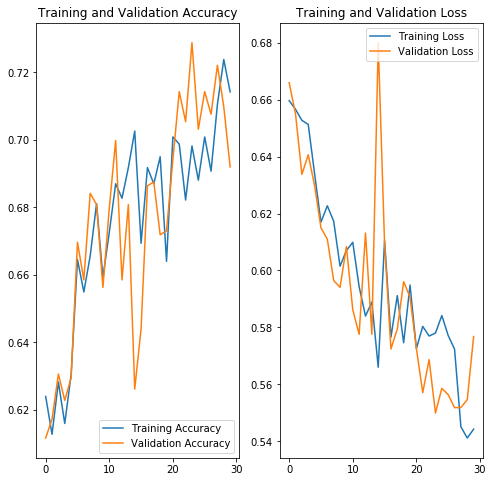

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs*2)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Training Accuracy')
plt.plot(epochs_range,val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Training Loss')
plt.plot(epochs_range,val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()